<a href="https://colab.research.google.com/github/FokaKefir/KepKreator/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Uncomment when running in colab
!pip install wandb
!pip install keras_tuner
!git clone https://github.com/FokaKefir/KepKreator.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00
Cloning into 'KepKreator'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 222 (delta 16), reused 34 (delta 10), pack-reused 178
Receiving objects: 100% (222/222), 20.40 MiB | 7.98 MiB/s, done.
Resolving deltas: 100% (105/105), done.


# Import dependecies

In [4]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, Input, Flatten, Reshape, Embedding, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow import keras
import keras_tuner

import numpy as np
import matplotlib.pyplot as plt

import wandb
import sys, os

VAL_MODEL_PATH = '/content/KepKreator/validation_cnn.hdf5' # '/kaggle/working/KepKreator/validation_cnn.hdf5'
PROJECT = 'KepKreator'
WANDB_IMAGE_NUM = 8
VAL_METRIC_N_SAMPLE = 1024
USE_WANDB = False # True: during training
N_CLASSES = 10

# disable warnings
tf.get_logger().setLevel('ERROR')
if USE_WANDB:
    wandb.login()

# Preprocess the data

## Load data

In [5]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
x_train = np.concatenate([x_train, x_test])
labels_train = np.concatenate([labels_train, labels_test])

11490434/11490434 [==============================] - 2s 0us/step


## Plot some random examples

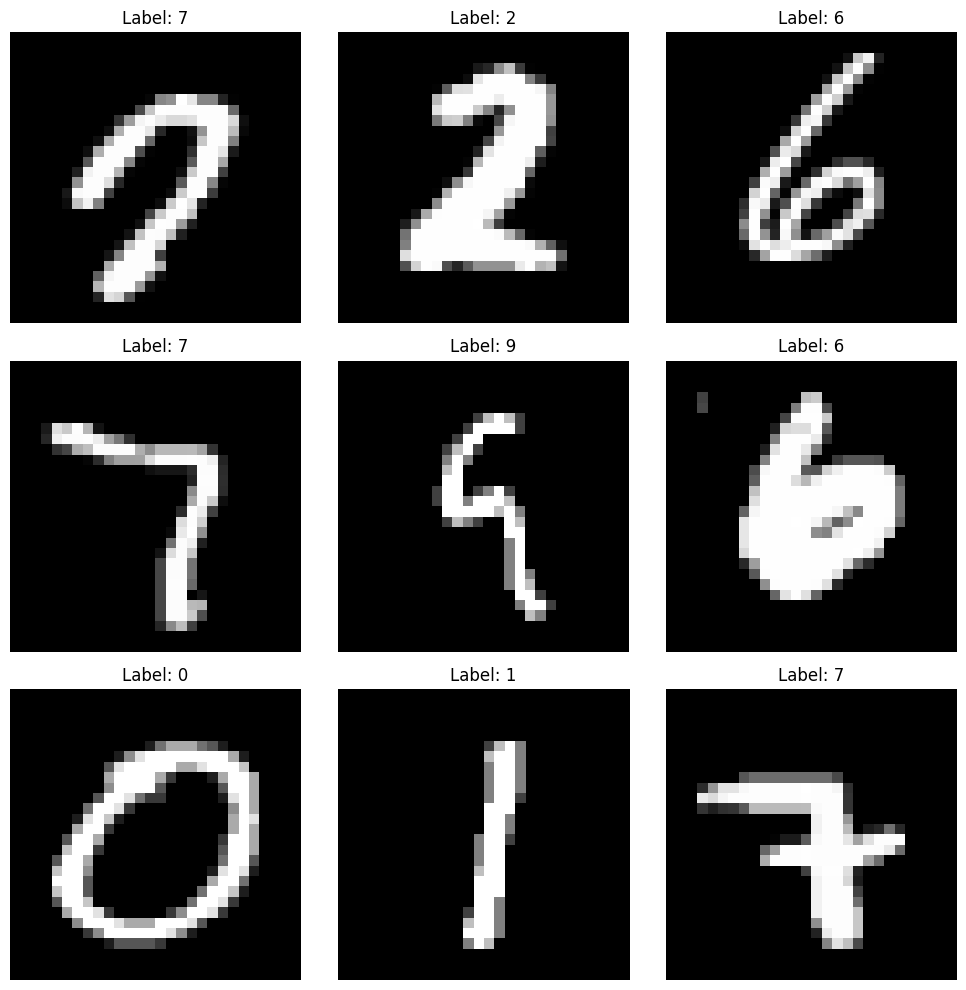

In [6]:
def show_images(examples):
  random_indices = np.random.choice(examples.shape[0], 9, replace=False)

  # rescale images (-1, +1) -> (0, 1)
  examples = 0.5 * examples + 0.5

  plt.figure(figsize=(10, 10))
  for i, index in enumerate(random_indices, 1):
      plt.subplot(3, 3, i)
      plt.imshow(x_train[index], cmap='gray')
      plt.title(f"Label: {labels_train[index]}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

show_images(x_train)

# Evaluation metrics for the generated images

Possible metrics:

* inception score
    * [medium article](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a)
    * [short code introduction](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/)
* parzen window estimation
* conditional inception scores
    * [Evaluation Metrics for Conditional Image Generation](https://arxiv.org/abs/2004.12361)
* Frechet inception distance
* kernel inception distance
    * [KID code and GAN tips and trics](https://keras.io/examples/generative/gan_ada/#dataefficient-gans-with-adaptive-discriminator-augmentation)

## Conditional inception scores and inception score:

In [7]:
def kl_divergence(a, b):
   '''Kullback-Leibler divergence
   Smaller value means more similar distributions'''
   a, b = np.atleast_2d(np.asarray(a)), np.atleast_2d(np.asarray(b))
   eps = 1e-16
   Dkls = a * np.log((a + eps) / (b + eps))
   return Dkls.sum(axis=1)

class InceptionScore(keras.metrics.Metric):
    '''Inception score
    IS = exp( Ex{ Dkl( pG_yx || pG_y ) } )'''

    def __init__(self, name='inception_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mean_tracker = keras.metrics.Mean()

    def update_state(self, y_hat):
        IS = self._inception_score(y_hat)
        self.mean_tracker.update_state(IS)

    def result(self):
        return self.mean_tracker.result()

    def reset_state(self):
        self.mean_tracker.reset_state()

    def _inception_score(self, y_hat):
        p_y = np.expand_dims(np.mean(y_hat, axis=0), 0)
        # kl divergence for each image
        Dkls = kl_divergence(y_hat, p_y)
        return np.exp(Dkls.mean())

class WithinClassInceptionScore(keras.metrics.Metric):
    '''Within-class inception score
    Measures the quality and diversity for each of the classes.
    High WCIS indicates a wide coverage of real classes within the
    conditioned classes, which is an undesired property.
    wcis = exp( Ec{ Dkl( pG_yx || pG_yc ) } )'''

    def __init__(self, name='within_class_inception_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mean_tracker = keras.metrics.Mean()

    def update_state(self, y_hat, gen_labels):
        wcis = self._wcis(y_hat, gen_labels)
        self.mean_tracker.update_state(wcis)

    def result(self):
        return self.mean_tracker.result()

    def reset_state(self):
        self.mean_tracker.reset_state()

    def _wcis(self, y_hat, labels):
        classes = np.unique(labels)
        Dkl = np.ndarray(len(classes))

        I = np.ndarray(len(classes))
        for i, cond in enumerate(classes):
            # mean of pG_yx with the given condition, as in BCIS
            pG_yc = np.expand_dims(np.mean(y_hat[labels == cond], axis=0), 0)
            # x is sampled from the given class
            pG_yx = y_hat[labels == cond]
            # kl divergence for each sample within the class
            Dkl = kl_divergence(pG_yx, pG_yc)
            I[i] = Dkl.mean(axis=0)
        return np.exp(I.mean())

class BetweenClassInceptionScore(keras.metrics.Metric):
    '''Between-class inception score
    Measures how close the representation of classes is to real data.
    Higher BCIS is better, it indicates the distinct class representation
    of the conditioned classes and a wide coverage across the conditional
    classes, which is desired.
    bcis = exp( Ec{ Dkl( pG_yc || pG_y ) } )'''

    def __init__(self, name='between_class_inception_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mean_tracker = keras.metrics.Mean()

    def update_state(self, y_hat, gen_labels):
        bcis = self._bcis(y_hat, gen_labels)
        self.mean_tracker.update_state(bcis)

    def result(self):
        return self.mean_tracker.result()

    def reset_state(self):
        self.mean_tracker.reset_state()

    def _bcis(self, y_hat, labels):
        pG_y = np.expand_dims(np.mean(y_hat, axis=0), 0) # mean for all generated samples of pG_yx

        classes = np.unique(labels)
        Dkl = np.ndarray(len(classes))
        for i, cond in enumerate(classes):
            # mean on classes of the pG_yx values
            pG_yc = np.expand_dims(np.mean(y_hat[labels == cond], axis=0), 0)
            Dkl[i] = kl_divergence(pG_yc, pG_y)[0]
        return np.exp(Dkl.mean())


# Define Model


In [8]:
class CGAN(tf.keras.Model):
  def __init__(self, config):
    super(CGAN, self).__init__()

    self.latent_dim = config['latent_dim']
    self.n_classes = config['n_classes']

    # create generator
    self.generator = self.build_generator(
      latent_dim=self.latent_dim, n_classes=self.n_classes, label_embedding=config['gen_label_embedding'],
      label_hidden=config['gen_label_hidden'], input_hidden=config['gen_input_hidden'],
      conv1_channels=config['gen_conv1_channels'], conv2_channels=config['gen_conv2_channels'])

    # create discriminator
    self.discriminator = self.build_discriminator(
      n_classes=self.n_classes, label_embedding=config['disc_label_embedding'],
      conv1_channels=config['disc_conv1_channels'], conv2_channels=config['disc_conv2_channels'],
      dense_hidden=config['disc_dense_hidden'])

    # classificator model used for validation
    self.val_model = load_model(VAL_MODEL_PATH)

    # add tracker
    self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
    self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
    self.real_accuracy_tracker = keras.metrics.BinaryAccuracy(name="real_accuracy")
    self.fake_accuracy_tracker = keras.metrics.BinaryAccuracy(name="fake_accuracy")
    self.is_tracker = InceptionScore()
    self.wcis_tracker = WithinClassInceptionScore()
    self.bcis_tracker = BetweenClassInceptionScore()

  @property
  def metrics(self):
    return [self.gen_loss_tracker,
            self.disc_loss_tracker,
            self.real_accuracy_tracker,
            self.fake_accuracy_tracker,
            self.is_tracker,
            self.wcis_tracker,
            self.bcis_tracker,]

  @property
  def train_metrics(self):
    return [self.gen_loss_tracker,
            self.disc_loss_tracker,
            self.real_accuracy_tracker,
            self.fake_accuracy_tracker,]

  @property
  def val_metrics(self):
    return [self.is_tracker,
            self.wcis_tracker,
            self.bcis_tracker,]

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    tf.config.run_functions_eagerly(True)

    # set optimizers
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer

    # set loss function
    self.loss_fn = loss_fn

    super(CGAN, self).compile()

  def generate_latent_points(self, n_samples):
    x_input = np.random.randn(self.latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, self.latent_dim)
    x_labels = np.random.randint(0, self.n_classes, n_samples)
    return [x_input, x_labels]

  def generate_fake_samples(self, n_samples):
    # generate points in latent space
    x_input, x_labels = self.generate_latent_points(n_samples)

    # predict outputs
    imgs = self.generator([x_input, x_labels], training=False)

    # create class labels
    y = np.zeros((n_samples, 1))
    return [imgs, x_labels], y

  @tf.function
  def train_step(self, data):
    # Unpack the data
    real_images, real_labels = data

    # Get batch size
    batch_size = tf.shape(real_images)[0]

    # Get randomly selected 'real' samples, with labels
    x_real, y_real = [real_images, real_labels], np.ones((batch_size, 1))

    # Update discriminator model weights
    with tf.GradientTape() as tape:
      real_predictions = self.discriminator(x_real)
      d_loss_real = self.loss_fn(y_real, real_predictions)
    grads = tape.gradient(d_loss_real, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Generate 'fake' examples, with labels
    x_fake, y_fake = self.generate_fake_samples(batch_size)

    # Update discriminator model weights
    with tf.GradientTape() as tape:
      fake_predictions = self.discriminator(x_fake)
      d_loss_fake = self.loss_fn(y_fake, fake_predictions)
    grads = tape.gradient(d_loss_fake, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Calculate loss
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # Prepare points in latent space as input for the generator
    x_gan = self.generate_latent_points(2 * batch_size)

    # Create inverted labels for the fake samples
    y_gan = np.ones((2 * batch_size, 1))

    # Update the generator via the discriminator's error
    with tf.GradientTape() as tape:
      fake_imgs = self.generator(x_gan)
      fake_imgs_and_labels = [fake_imgs, x_gan[1]]
      predictions = self.discriminator(fake_imgs_and_labels)
      g_loss = self.loss_fn(y_gan, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Monitor loss
    self.gen_loss_tracker.update_state(g_loss)
    self.disc_loss_tracker.update_state(d_loss)
    self.fake_accuracy_tracker.update_state(0.0, fake_predictions)
    self.real_accuracy_tracker.update_state(1.0, real_predictions)
    return {metric.name: metric.result() for metric in self.train_metrics}

  def build_discriminator(self, in_shape=(28, 28, 1), n_classes=10, label_embedding=50,
                          conv1_channels=32, conv2_channels=64, dense_hidden=128, use_batchnorm=False):
    # label input
    i_label = Input(shape=(1, ))
    x_label = Embedding(n_classes, label_embedding)(i_label)
    x_label = Dense(in_shape[0] * in_shape[1], activation='tanh')(x_label)
    x_label = Reshape((in_shape[0], in_shape[1], 1))(x_label)

    # image input
    i_img = Input(shape=in_shape)

    # concatenate
    x = Concatenate()([x_label, i_img])

    # conv layers
    x = Conv2D(conv1_channels, (3, 3), strides=(2, 2), padding='same', activation='tanh')(i_img)
    x = Conv2D(conv2_channels, (3, 3), strides=(2, 2), padding='same', activation='tanh')(x)
    x = Flatten()(x)
    x = Dense(dense_hidden, activation='tanh')(x)
    if use_batchnorm:
      x = keras.layers.BatchNormalization()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model([i_img, i_label], x)
    return model

  def build_generator(self, latent_dim=50, n_classes=10, label_embedding=50,
                      label_hidden=16, input_hidden=16,
                      conv1_channels=128, conv2_channels=128):
    # label input
    i_label = Input(shape=(1, ))
    x_label = Embedding(n_classes, label_embedding)(i_label)
    x_label = Dense(7 * 7 * label_hidden, activation='tanh')(x_label)
    x_label = Reshape((7, 7, label_hidden))(x_label)

    # foundation for 7x7 image
    i_lat = Input(shape=(latent_dim, ))
    x_lat = Dense(7 * 7 * input_hidden, activation='tanh')(i_lat)
    x_lat = Reshape((7, 7, input_hidden))(x_lat)

    # concatenate
    x = Concatenate()([x_lat, x_label])

    # upsample to 14x14
    x = Conv2DTranspose(conv1_channels, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    # upsample to 28x28
    x = Conv2DTranspose(conv2_channels, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    # make only one color channel, values in (-1, +1)
    x = Conv2D(1, (7, 7), activation='tanh', padding='same')(x)
    return Model([i_lat, i_label], x)

  def sample_images(self, e=0, b=0, method='show'):
    if not os.path.exists('gan_images'):
      os.makedirs('gan_images')

    data, _ = self.generate_fake_samples(25)
    imgs, labels = data
    rows, cols = 5, 5

    # Rescale images (-1, +1) -> (0, 1)
    imgs = 0.5 * imgs + 0.5

    if method == 'show' or method == 'save':
      fig, axs = plt.subplots(rows, cols, figsize=(9, 10))
      idx = 0
      for i in range(rows):
        for j in range(cols):
          axs[i, j].imshow(imgs[idx], cmap='gray')
          axs[i, j].set_title(f'num: {labels[idx]}')
          axs[i, j].axis('off')
          idx += 1

    if method == 'show':
      plt.show()
    elif method == 'save':
      fig.savefig(f'gan_images/sample_{e:003d}_{b:0004d}.png')
      plt.close()
    elif method == 'wandb':
      columns = ['epoch', 'batch', 'label_num', 'image']
      im_table = wandb.Table(columns=columns)
      for row in range(WANDB_IMAGE_NUM):
        im_table.add_data(e, b, labels[row], wandb.Image(imgs[row]))
      wandb.log({'generated_examples': im_table})

  @tf.function
  def test_step(self, data):
    gen_images_and_labels, _ = self.generate_fake_samples(VAL_METRIC_N_SAMPLE)

    gen_images, gen_labels = gen_images_and_labels[0], gen_images_and_labels[1]
    y_hat = self.val_model(gen_images, training=False)

    self.is_tracker.update_state(y_hat)
    self.bcis_tracker.update_state(y_hat, gen_labels)
    self.wcis_tracker.update_state(y_hat, gen_labels)

    return {metric.name: metric.result() for metric in self.val_metrics}

  # save models
  def save(self, filepath, overwrite=True, save_format=None, **kwargs):
    self.generator.save(filepath + 'generator.h5')
    self.discriminator.save(filepath + 'discriminator.h5')

  # load models
  def load_models(self, generator_path, discriminator_path):
    self.generator = load_model(generator_path, compile=False)
    self.discriminator = load_model(discriminator_path, compile=False)


# Train the Model

## Define callbacks


In [9]:
class SamplerCallback(tf.keras.callbacks.Callback):
  def __init__(self, sample_freq: int=1):
    super().__init__()
    self.sample_freq = sample_freq
    self.e = 0

  def on_epoch_begin(self, epoch, logs=None):
    self.e = epoch

  def on_train_batch_end(self, batch: int, logs=None):
    if batch % self.sample_freq == 0:
      method = 'wandb' if USE_WANDB else 'save'
      self.model.sample_images(self.e + 1, batch, method=method)

In [10]:
import gc

class GarbageCollectorCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

# Hypermodel for hiperparameter optimization

Sources:

* [keras documentation for hyperparameter tuning with custom training loop](https://keras.io/guides/keras_tuner/custom_tuner/)
* [kaggle notebook baout using keras-tuner with wandb](https://www.kaggle.com/code/aritrag/keras-tuner-with-wandb/notebook)
* [keras documentation for keras-tuner Tuners](https://keras.io/guides/keras_tuner/getting_started/#tune-model-training)


In [11]:
class CGANHypermodel(keras_tuner.HyperModel):
    def build(self, hp):
        config = {
            'latent_dim': hp.Int('latent_dim', min_value=32, max_value = 128, step = 32),
            'gen_label_embedding': hp.Choice('gen_label_embedding', [10, 25, 50]),
            'gen_label_hidden': hp.Choice('gen_label_hidden', [1, 4, 8, 16, 32]),
            'gen_input_hidden': hp.Choice('gen_input_hidden', [32, 64, 96]),
            'gen_conv1_channels': hp.Choice('gen_conv1_channels', [16, 64, 128]),
            'gen_conv2_channels': hp.Choice('gen_conv2_channels', [64, 128, 256]),
            'disc_label_embedding': hp.Choice('disc_label_embedding', [10, 25, 50]),
            'disc_conv1_channels': hp.Choice('disc_conv1_channels', [16, 64, 128]),
            'disc_conv2_channels': hp.Choice('disc_conv2_channels', [64, 128, 256]),
            'disc_dense_hidden': hp.Choice('disc_dense_hidden', [32, 64, 128]),
            'disc_use_batchnorm': hp.Boolean('disc_use_batchnorm'),
            'n_classes': hp.Fixed('n_classes', N_CLASSES),
            'batch_size': hp.Fixed('batch_size', 32),
            'n_val': hp.Fixed('n_val', VAL_METRIC_N_SAMPLE),
            'VAL_MODEL_PATH': hp.Fixed('VAL_MODEL_PATH', VAL_MODEL_PATH),
            'gen_learning_rate': hp.Fixed('gen_learning_rate', 0.0002),
            'gen_adam_beta1': hp.Fixed('gen_adam_beta1', 0.5),
            'discr_learning_rate': hp.Fixed('discr_learning_rate', 0.0002),
            'discr_adam_beta1': hp.Fixed('discr_adam_beta1', 0.5),
        }
        # saving the keys to easily get config in fit()
        self.last_build_config_keys = config.keys()
        # building the CGAN
        cgan = CGAN(config)
        cgan.compile(
            d_optimizer=Adam(learning_rate=config['discr_learning_rate'],
                            beta_1=config['discr_adam_beta1']),
            g_optimizer=Adam(learning_rate=config['gen_learning_rate'],
                            beta_1=config['gen_adam_beta1']),
            loss_fn=BinaryCrossentropy(from_logits=False)
        )
        return cgan

    def get_current_config(self, hp):
        return {key: hp.get(key) for key in self.last_build_config_keys}

    def fit(self, hp, model, x, y, wandb_config, *args, **kwargs):
        config = self.get_current_config(hp)
        with wandb.init(project=PROJECT, config=config, mode=wandb_config['mode'],
                        group=wandb_config['group']):
            # defining callback, wandb callback is only possible after wandb.init
            wandbcb = wandb.keras.WandbCallback(
                monitor="val_within_class_inception_score", mode="min",
                save_model=False, log_batch_frequency=50)
            sampler = SamplerCallback(sample_freq=100)
            garbage_collector = GarbageCollectorCallback()
            # adding the callbacks to the automatic ones
            kwargs['callbacks'].extend([sampler, garbage_collector, wandbcb])

            ret = model.fit(x, y, *args,
                            batch_size=config['batch_size'],
                            **kwargs)
        return ret

In [ ]:
mode = None if USE_WANDB else 'disabled'
group_name = 'hyperparam_optimization_hyperband_12_09_v3'
wandb_config = {'mode': mode,
                'group': group_name}

tuner = keras_tuner.RandomSearch(
    CGANHypermodel(),
    objective=keras_tuner.Objective('val_within_class_inception_score', 'min'),
    max_trials=20,
    overwrite=True,
    directory='hyperparam_tuning',
    project_name=PROJECT,
)

# tuner = keras_tuner.Hyperband(
#     CGANHypermodel(),
#     objective=keras_tuner.Objective('val_within_class_inception_score', 'min'),
#     factor=6,
#     max_epochs=20,
#     directory='hyperparam_tuning_hyperband_12_09_v3',
#     project_name=PROJECT,
# )

tuner.search(x_train, labels_train,
            wandb_config,
            epochs=8, # only for RandomSearch
            validation_data=[x_test[0]],
            )

print(tuner.get_best_hyperparameters()[0].values)

# Create models and train


In [ ]:
config = {'latent_dim': 96,
          'gen_label_embedding': 10,
          'gen_label_hidden': 8,
          'gen_input_hidden': 96,
          'gen_conv1_channels': 64,
          'gen_conv2_channels': 64,
          'disc_label_embedding': 10,
          'disc_conv1_channels': 64,
          'disc_conv2_channels': 128,
          'disc_dense_hidden': 128,
          'disc_use_batchnorm': False,
          'n_classes': N_CLASSES,
          'epochs': 10,
          'batch_size': 32,
          'n_val': VAL_METRIC_N_SAMPLE,
          'VAL_MODEL_PATH': VAL_MODEL_PATH,
          'gen_learning_rate': 0.0002,
          'gen_adam_beta1': 0.5,
          'discr_learning_rate': 0.0002,
          'discr_adam_beta1': 0.5}
mode = None if USE_WANDB else 'disabled'
group_name = 'mnist_long'
with wandb.init(project=PROJECT, config=config, mode=mode, group=group_name):
    cgan = CGAN(config)

    cgan.compile(
        d_optimizer=Adam(learning_rate=config['discr_learning_rate'],
                         beta_1=config['discr_adam_beta1']),
        g_optimizer=Adam(learning_rate=config['gen_learning_rate'],
                         beta_1=config['gen_adam_beta1']),
        loss_fn=BinaryCrossentropy(from_logits=False)
    )

    wandbcb = wandb.keras.WandbCallback(monitor="val_within_class_inception_score",
                                        mode="min", save_model=False, log_batch_frequency=50)
    checkpointer = ModelCheckpoint(
        'models/{epoch:002d}/', verbose=0, save_best_only=False,
        save_weights_only=False, mode='auto', save_freq=1000)
    sampler = SamplerCallback(sample_freq=1000)
    garbage_collector = GarbageCollectorCallback()

    cgan.fit(
        x_train, labels_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=[x_test[0]], #dummy validation data
        callbacks=[
            checkpointer,
            sampler,
            garbage_collector,
            wandbcb
        ]
    )

# Load model

In [ ]:
e = 1
cgan = CGAN(config)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

In [ ]:
e = 3
cgan = CGAN(config)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

In [ ]:
e = 5
cgan = CGAN(config)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

In [ ]:
e = 7
cgan = CGAN(config)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

In [ ]:
e = 9
cgan = CGAN(config)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

In [ ]:
e = 10
cgan = CGAN(config)
cgan.load_models(f'models/{e:02d}/generator.h5', f'models/{e:02d}/discriminator.h5')
cgan.sample_images(method='show')

# Download models

In [ ]:
!zip -r /content/models.zip /content/models

In [ ]:
from google.colab import files
files.download("/content/models.zip")